In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from regression import LinearRegression
from sklearn.cluster import DBSCAN

## Dataset reading and describing

In [3]:
df = pd.read_csv("datasets/insurance.csv", converters={
    "smoker": lambda val: 1 if val == "yes" else 0
})
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520


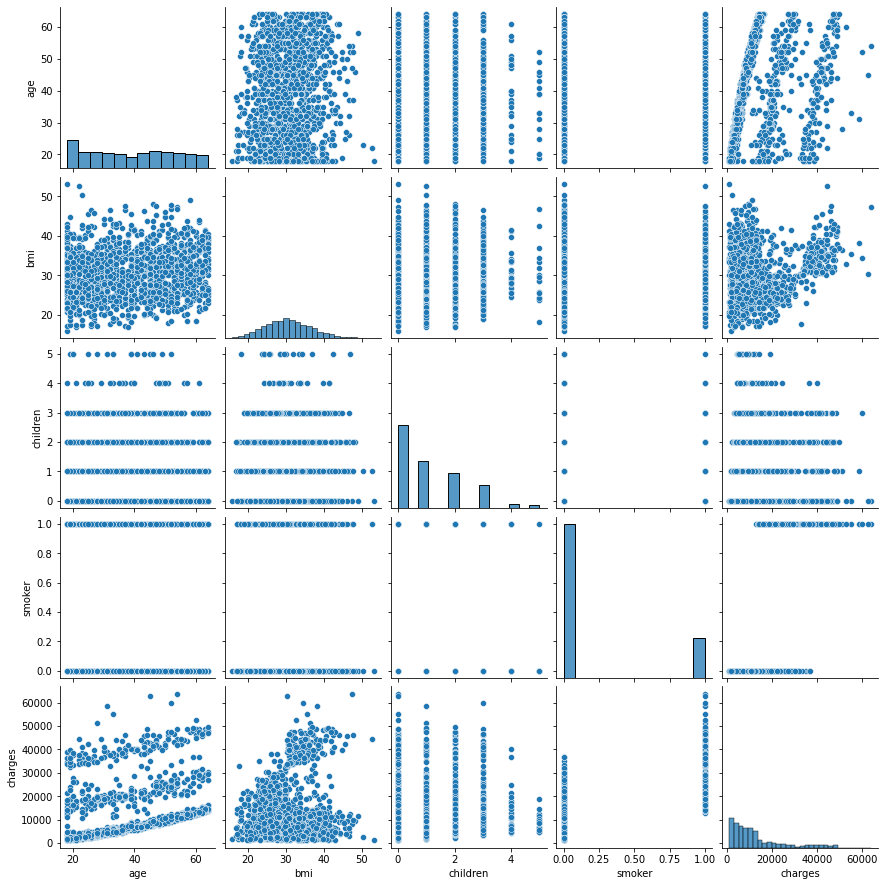

In [257]:
sns.pairplot(df[["age", "bmi", "children", "smoker", "charges"]])

In [ ]:
# mask = ((df["sex"] != "female") | (df["sex"] == "male")) &\
#        (df["smoker"] == 0) & \
#        (df["bmi"] >= 30)
#        # (df["age"] >= 30) & (df["age"] <= 40)
# dataset = df[mask][["age", "bmi", "charges"]]
# dataset.reset_index(inplace=True, drop=True)
# dataset.head()

## Clustering

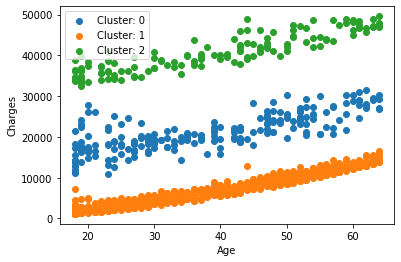

In [269]:
x = df[["age", "charges"]].to_numpy()
max_x = np.max(x, axis=0)
x = x / max_x
dbscan = DBSCAN(eps=.05, min_samples=5)
dbscan.fit(x)

clusters = []
for label in np.unique(dbscan.labels_):
    if label != -1:
        cluster = dbscan.labels_ == label
        clusters.append(cluster)
        cluster = x[cluster] * max_x
        plt.xlabel("Age")
        plt.ylabel("Charges")
        plt.scatter(cluster[:, 0], cluster[:, 1], label=f"Cluster: {label}")

plt.legend()

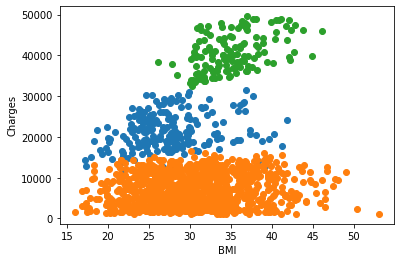

In [264]:
for cluster in clusters:
    _x = df.loc[cluster, "bmi"]
    _y = df.loc[cluster, "charges"]

    plt.xlabel("BMI")
    plt.ylabel("Charges")
    plt.scatter(_x, _y)

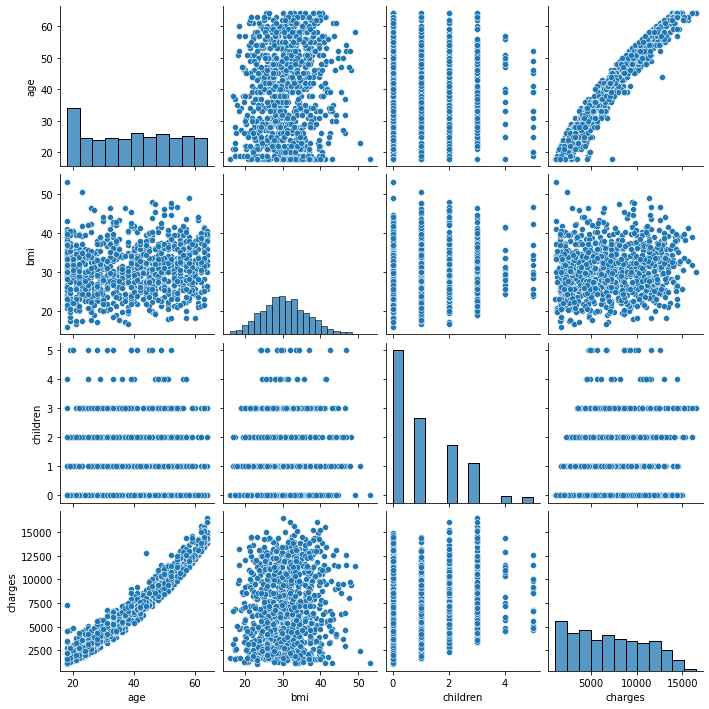

In [270]:
dataset = df.loc[clusters[1], ["age", "bmi", "children", "charges"]]
dataset.reset_index(inplace=True, drop=True)
sns.pairplot(dataset)

In [272]:
np.corrcoef(dataset.to_numpy().T)

array([[1.        , 0.12257373, 0.03594943, 0.97485695],
       [0.12257373, 1.        , 0.02125133, 0.11349631],
       [0.03594943, 0.02125133, 1.        , 0.16829704],
       [0.97485695, 0.11349631, 0.16829704, 1.        ]])

## Anomaly detection

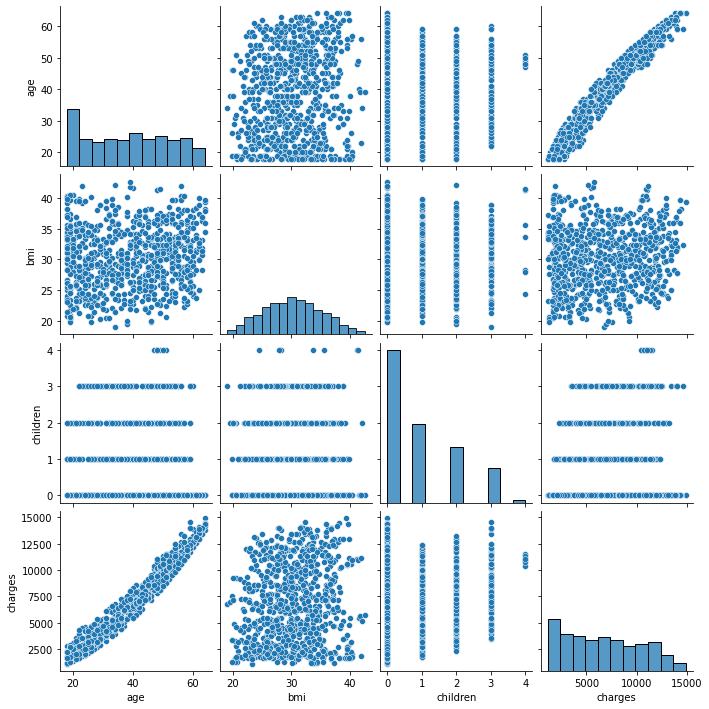

In [273]:

to_drop = []
for col in dataset.columns[:-1]:
    x = dataset[[col, dataset.columns[-1]]].to_numpy()
    x = x / np.max(x, axis=0)

    dbscan = DBSCAN(eps=.03, min_samples=5)
    dbscan.fit(x)
    to_drop = np.append(to_drop, np.argwhere(dbscan.labels_ == -1))

    # for label in np.unique(dbscan.labels_):
    #     if label != -1:
    #         cluster = dbscan.labels_ == label
    #         cluster = x[cluster]
    #         plt.scatter(cluster[:, 0], cluster[:, 1])

dataset = dataset.drop(np.unique(to_drop.astype(int)))
sns.pairplot(dataset)

In [274]:
np.corrcoef(dataset.to_numpy().T)

array([[ 1.        ,  0.1310833 ,  0.07353007,  0.98054208],
       [ 0.1310833 ,  1.        , -0.00631326,  0.12644143],
       [ 0.07353007, -0.00631326,  1.        ,  0.18363699],
       [ 0.98054208,  0.12644143,  0.18363699,  1.        ]])

## Model fitting

In [280]:
idxs = np.arange(0, len(dataset))
np.random.shuffle(idxs)

X = dataset.iloc[:, :-1].to_numpy()
X = np.concatenate([X[:, [0]], X[:, [0]] ** 2, X[:, 1:]], axis=1)
max_x = np.max(X, axis=0)
X = X / max_x

Y = dataset.iloc[:, -1].to_numpy()
max_y = np.max(Y)
Y = Y / max_y

n = int(0.5 * len(dataset))
X_train = X[idxs[:n]]
Y_train = Y[idxs[:n]]

X_test = X[idxs[n:]]
Y_test = Y[idxs[n:]]

linregr = LinearRegression()
linregr.train(X_train, Y_train)

linregr.MSE(X_test, Y_test), linregr.w, linregr.MSE(X_test, Y_test) / min(Y)

(0.0005203646180203082,
 array([ 0.05627263,  0.00380916,  0.92254038, -0.02963148,  0.15810426]))

In [282]:
linregr_l1 = LinearRegression(l1=.05)
linregr_l1.train(X_train, Y_train)

linregr_l1.MSE(X_test, Y_test), linregr_l1.w, linregr_l1.MSE(X_test, Y_test) / min(Y)

(0.005172299247905103,
 array([ 2.38939462e-02,  3.88102042e-01,  4.14951578e-01, -1.66918002e-09,
         1.29486873e-03]),
 0.06870210958651889)

In [285]:
linregr_l2 = LinearRegression(l2=.05)
linregr_l2.train(X_train, Y_train)

linregr_l2.MSE(X_test, Y_test), linregr_l2.w, linregr_l2.MSE(X_test, Y_test) / min(Y)

(0.005674050299362438,
 array([0.04548286, 0.32727739, 0.39464294, 0.03622611, 0.0919953 ]),
 0.07536671928332532)

In [19]:
from sklearn.linear_model import LinearRegression as skLR

reg = skLR().fit(X_train, Y_train)
reg.coef_, reg.intercept_

(array([0.25224707, 0.24517499]), -0.08751142773128381)

In [250]:
prediction = linregr.predict(X_test) * max_y
axes = X_test * max_x

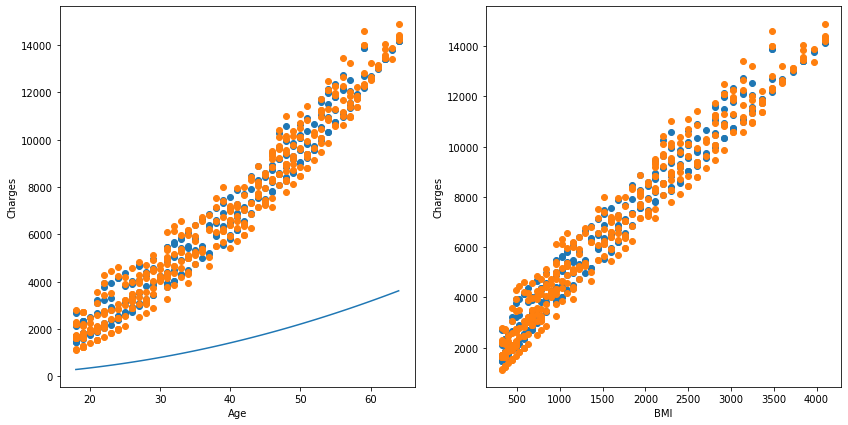

In [253]:
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(121)
ax1.set_xlabel("Age")
ax1.set_ylabel("Charges")
ax1.scatter(axes[:, 0], prediction)
ax1.scatter(axes[:, 0], Y_test * max_y)

x = np.linspace(np.min(axes[:, 0]), np.max(axes[:, 0]), 100)
y = linregr.w[0] + linregr.w[1] * x + linregr.w[2] * x ** 2
ax1.plot(x, y)

ax2 = fig.add_subplot(122)
ax2.set_xlabel("BMI")
ax2.set_ylabel("Charges")
ax2.scatter(axes[:, 1], prediction)
ax2.scatter(axes[:, 1], Y_test * max_y)

In [ ]:
plt.scatter(axes[:, 1], prediction, xlabel="BMI", y_label="Charges")

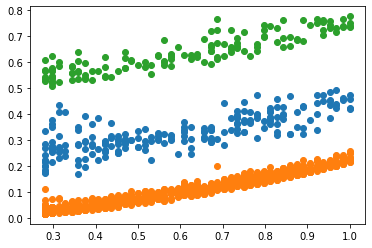